https://learn.astropy.org/tutorials/synthetic-images.html

https://chatgpt.com/share/694e6d7f-f60c-8007-bc47-5041e3c0bfba

In [2]:
from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
file_i = download_file(
    "http://data.astropy.org/tutorials/synthetic-images/synchrotron_i_lobe_0700_150MHz_sm.fits",
    cache=True,
)
hdulist = fits.open(file_i)
hdulist.info()

hdu = hdulist["NN_EMISSIVITY_I_LOBE_150.0MHZ"]
hdu.header

Filename: C:\Users\Soham Das\.astropy\cache\download\url\8da27de5aa6b0db633441e82715bedf3\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  NN_EMISSIVITY_I_LOBE_150.0MHZ    1 ImageHDU        23   (1024, 1452)   float64   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1452                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =                512.0                                                  
CRPIX2  =                726

129.7177858088622
0.0


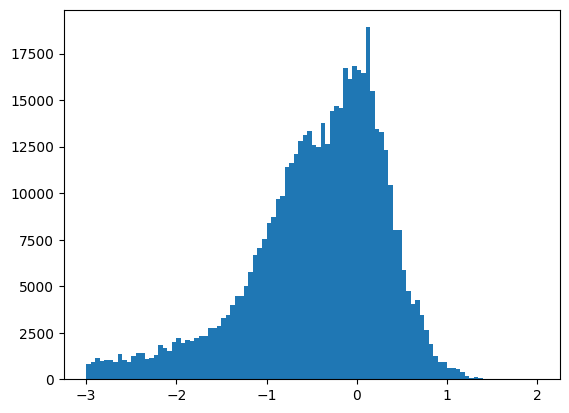

In [4]:
print(hdu.data.max())
print(hdu.data.min())
np.seterr(
    divide="ignore"
)  # suppress the warnings raised by taking log10 of data with zeros
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100);

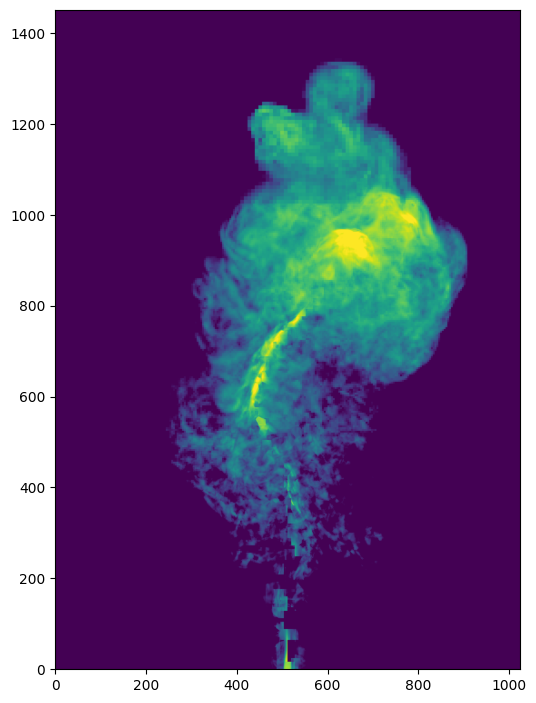

In [5]:
fig = plt.figure(figsize=(6, 12))
fig.add_subplot(111)

# We plot it in log-scale and add a small number to avoid nan values.
plt.imshow(np.log10(hdu.data + 1e-3), vmin=-1, vmax=1, origin="lower")

In [7]:
# distance to the object
dist_obj = 200 * u.Mpc

ra_obj = "19h59m28.3566s"
dec_obj = "+40d44m02.096s"

cdelt1 = ((hdu.header["CDELT1"] * u.cm / dist_obj.to("cm")) * u.rad).to("deg")
cdelt2 = ((hdu.header["CDELT2"] * u.cm / dist_obj.to("cm")) * u.rad).to("deg")
print(cdelt1, cdelt2)

8.74922223983974e-06 deg 8.74922223983974e-06 deg


In [8]:
w = WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0] / 2, hdu.data.shape[1] / 2]

# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# converting ra and dec into degrees
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

# the units of the axes are in degrees
w.wcs.cunit = ["deg", "deg"]

wcs_header = w.to_header()
hdu.header.update(wcs_header)

hdu.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1452                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                726.0 / Pixel coordinate of reference point            
CRPIX2  =                512

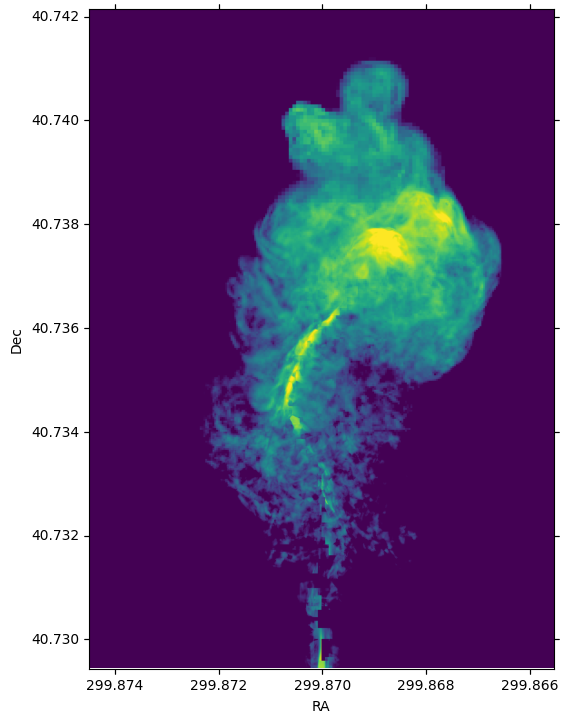

In [9]:
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(6, 12))
fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(hdu.data + 1e-3), vmin=-1, vmax=1, origin="lower")
plt.xlabel("RA")
plt.ylabel("Dec")

In [10]:
# assume that the telescope has 1 arcsecond resolution
telescope_resolution = 1 * u.arcsecond

# calculate the sigma in pixels
sigma = telescope_resolution.to("deg") / cdelt2

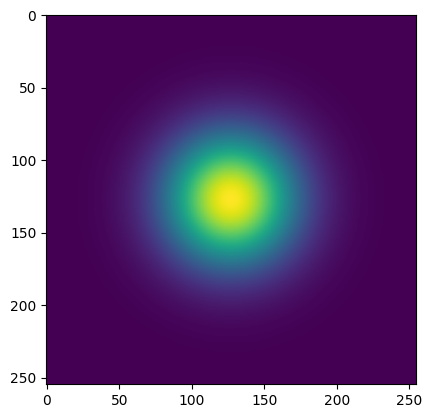

In [11]:
# By default, the Gaussian kernel will go to 4 sigma in each direction
psf = Gaussian2DKernel(sigma)

plt.imshow(psf.array.value)

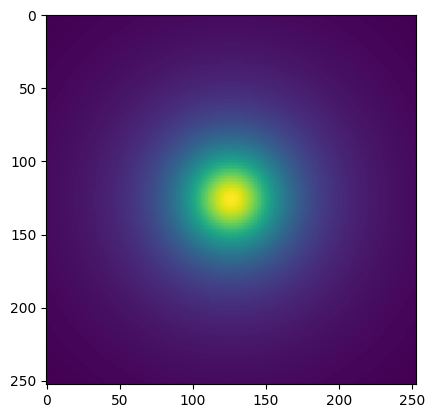

In [12]:
# set FWHM and psf grid
telescope_resolution = 1 * u.arcsecond
gamma = telescope_resolution.to("deg") / cdelt2
x_grid = np.outer(
    np.linspace(-gamma * 4, gamma * 4, int(8 * gamma)), np.ones(int(8 * gamma))
)
r_grid = np.sqrt(x_grid**2 + np.transpose(x_grid**2))
lorentzian = Lorentz1D(fwhm=2 * gamma)

# extrude a 2D azimuthally symmetric PSF
lorentzian_psf = lorentzian(r_grid)

# normalization
lorentzian_psf /= np.sum(lorentzian_psf)

plt.imshow(lorentzian_psf.value, interpolation="none")

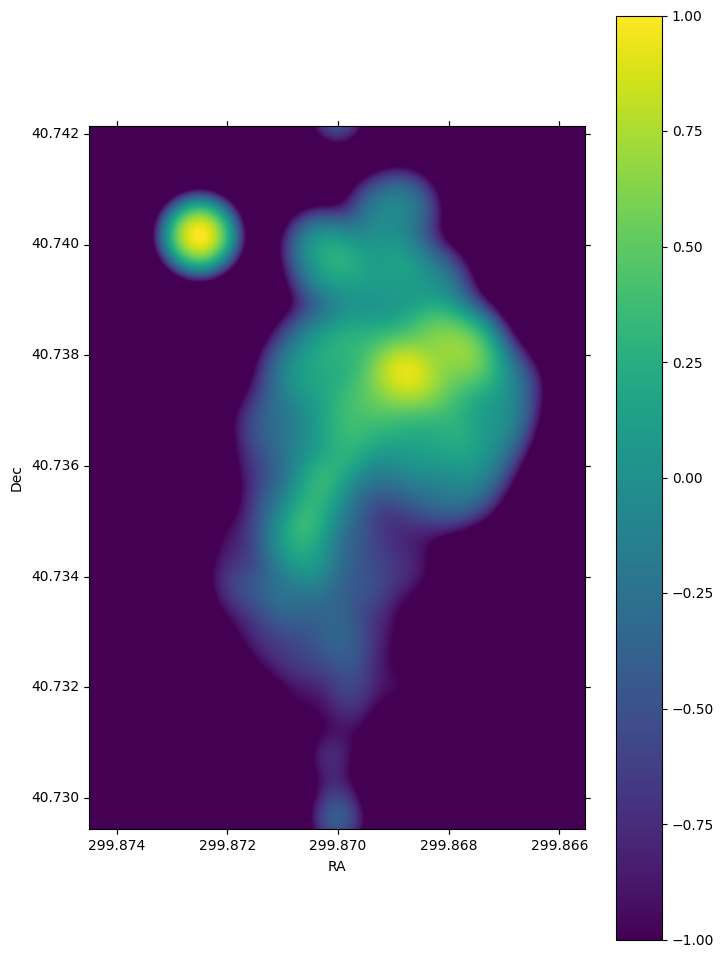

In [13]:
convolved_image = convolve_fft(hdu.data, psf, boundary="wrap")

# Put a psf at the corner of the image
delta_x_psf = 100  # number of pixels from the edges
xmin, xmax = -psf.shape[1] - delta_x_psf, -delta_x_psf
ymin, ymax = delta_x_psf, delta_x_psf + psf.shape[0]
convolved_image[xmin:xmax, ymin:ymax] = psf.array / psf.array.max() * 10

wcs = WCS(hdu.header)
fig = plt.figure(figsize=(8, 12))
i_plot = fig.add_subplot(111, projection=wcs)
plt.imshow(
    np.log10(convolved_image + 1e-3), vmin=-1, vmax=1.0, origin="lower"
)  # , cmap=plt.cm.viridis)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.colorbar()

In [14]:
hdulist.info()

Filename: C:\Users\Soham Das\.astropy\cache\download\url\8da27de5aa6b0db633441e82715bedf3\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  NN_EMISSIVITY_I_LOBE_150.0MHZ    1 ImageHDU        24   (1024, 1452)   float64   


In [15]:
file_q = download_file(
    "http://data.astropy.org/tutorials/synthetic-images/synchrotron_q_lobe_0700_150MHz_sm.fits",
    cache=True,
)
hdulist = fits.open(file_q)
hdu_q = hdulist["NN_EMISSIVITY_Q_LOBE_150.0MHZ"]

file_u = download_file(
    "http://data.astropy.org/tutorials/synthetic-images/synchrotron_u_lobe_0700_150MHz_sm.fits",
    cache=True,
)
hdulist = fits.open(file_u)
hdu_u = hdulist["NN_EMISSIVITY_U_LOBE_150.0MHZ"]

# Update the header with the wcs_header we created earlier
hdu_q.header.update(wcs_header)
hdu_u.header.update(wcs_header)

# Convolve the images with the the psf
convolved_image_q = convolve_fft(hdu_q.data, psf, boundary="wrap")
convolved_image_u = convolve_fft(hdu_u.data, psf, boundary="wrap")

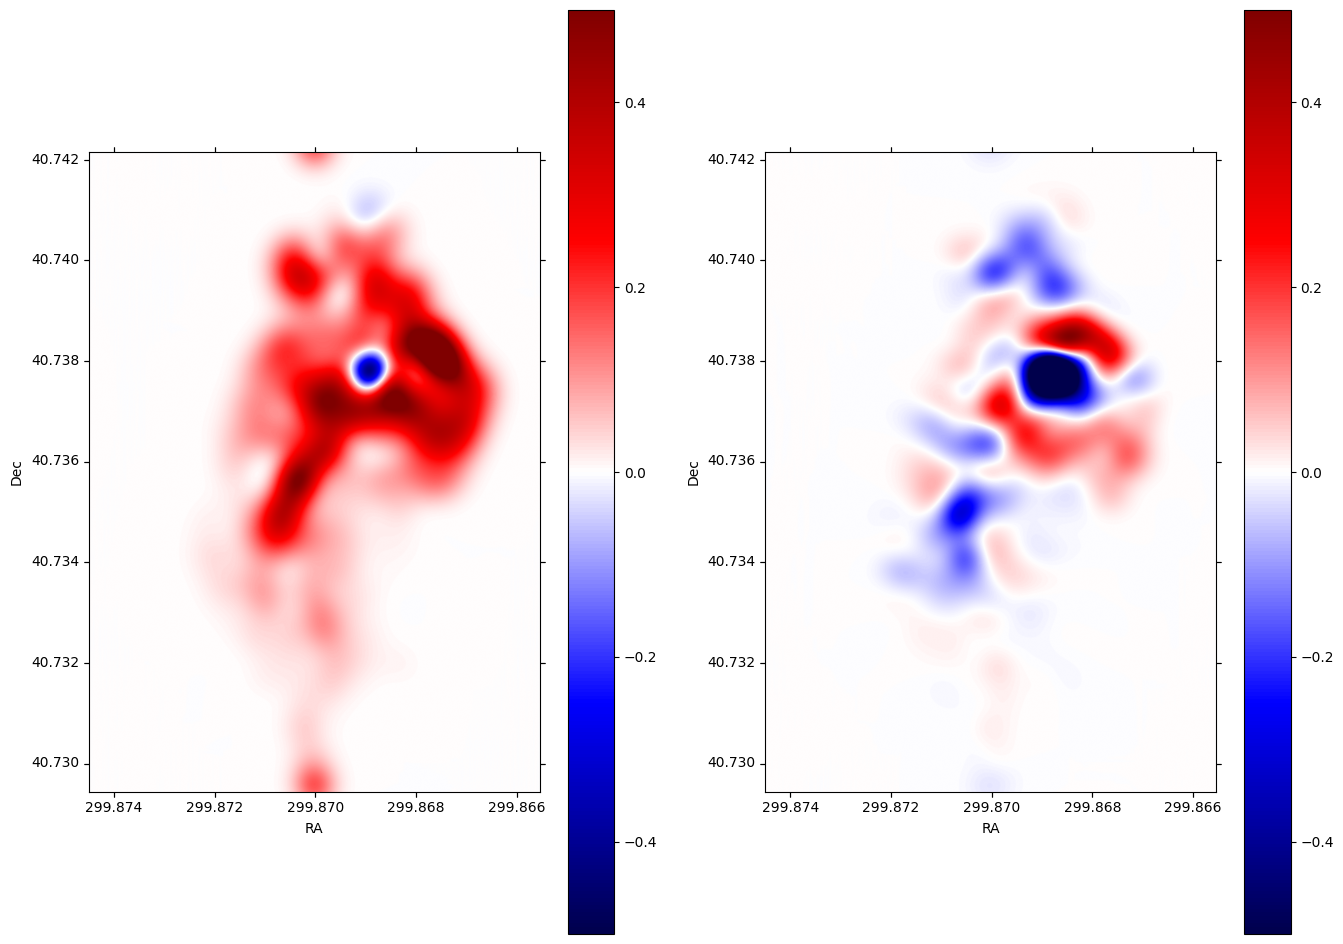

In [16]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(16, 12))
fig.add_subplot(121, projection=wcs)
plt.imshow(
    convolved_image_q, cmap="seismic", vmin=-0.5, vmax=0.5, origin="lower"
)  # , cmap=plt.cm.viridis)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.colorbar()

fig.add_subplot(122, projection=wcs)
plt.imshow(
    convolved_image_u, cmap="seismic", vmin=-0.5, vmax=0.5, origin="lower"
)  # , cmap=plt.cm.viridis)

plt.xlabel("RA")
plt.ylabel("Dec")
plt.colorbar()

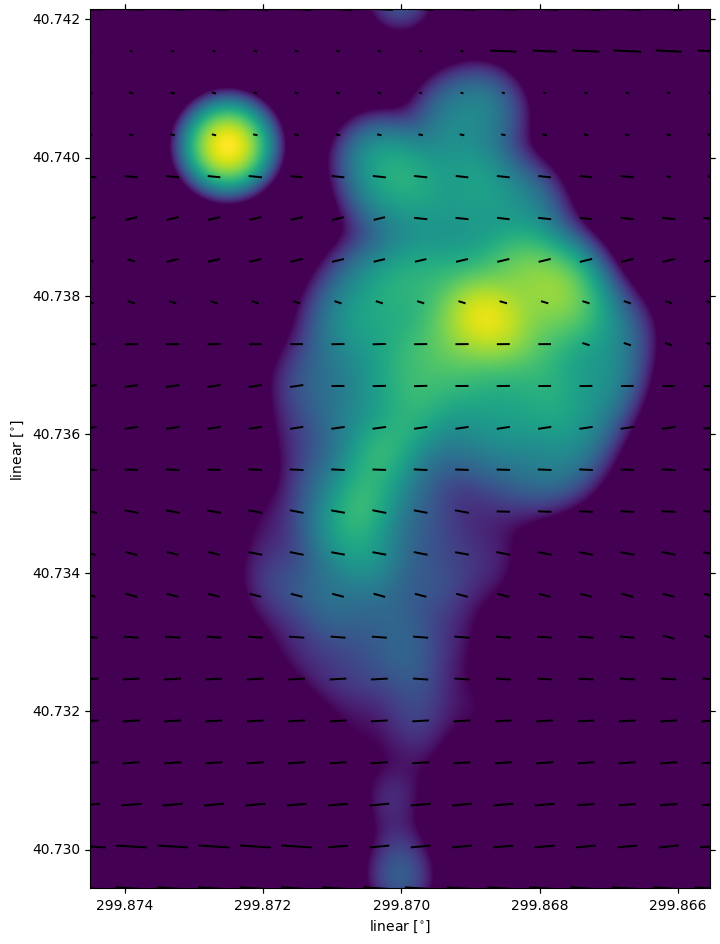

In [17]:
# plot the background image
fig = plt.figure(figsize=(8, 16))
i_plot = fig.add_subplot(111, projection=wcs)
i_plot.imshow(np.log10(convolved_image + 1e-3), vmin=-1, vmax=1, origin="lower")

# ranges of the axis
xx0, xx1 = i_plot.get_xlim()
yy0, yy1 = i_plot.get_ylim()

# binning factor
factor = [64, 66]

# re-binned number of points in each axis
nx_new = convolved_image.shape[1] // factor[0]
ny_new = convolved_image.shape[0] // factor[1]

# These are the positions of the quivers
X, Y = np.meshgrid(
    np.linspace(xx0, xx1, nx_new, endpoint=True),
    np.linspace(yy0, yy1, ny_new, endpoint=True),
)

# bin the data
I_bin = convolved_image.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
Q_bin = convolved_image_q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
U_bin = convolved_image_u.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

# polarization angle
psi = 0.5 * np.arctan2(U_bin, Q_bin)

# polarization fraction
frac = np.sqrt(Q_bin**2 + U_bin**2) / I_bin

# mask for low signal area
mask = I_bin < 0.1

frac[mask] = 0
psi[mask] = 0

pixX = frac * np.cos(psi)  # X-vector
pixY = frac * np.sin(psi)  # Y-vector

# keyword arguments for quiverplots
quiveropts = dict(headlength=0, headwidth=1, pivot="middle")
i_plot.quiver(X, Y, pixX, pixY, scale=8, **quiveropts)

**Exercise**

Convert the units of the data from Jy/arcsec^2 to Jy/beam

The intensity of the data is given in unit of Jy/arcsec^2. Observational data usually have the intensity unit in Jy/beam. Assuming a beam size or take the psf we created earlier, you can convert the data into Jy/beam.